## Final project Group 10：
Zihao Li, Lunjing Yuan, Haorui Cheng, Mengyao Song

In [1]:
# pip install -U imbalanced-learn

# pip install xgboost


In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.compose import make_column_transformer
import numpy as np
from imblearn.over_sampling import SMOTENC
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

# from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [3]:
credit = pd.read_csv('credit_record.csv')

In [4]:
application = pd.read_csv('application_record.csv')

## 1. Data preview

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [6]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
application.describe().drop(columns=['ID'],axis=1)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


### dealing some invalid values in employed days col and occupation col

In [8]:
application.DAYS_EMPLOYED.replace(to_replace=365243, value=np.nan, inplace=True)
application.OCCUPATION_TYPE.replace(to_replace=np.nan, value='Unknown', inplace=True)

In [9]:
application['DAYS_EMPLOYED']=application.DAYS_EMPLOYED.apply(lambda x: -x/365.25)
application['DAYS_BIRTH']=application.DAYS_BIRTH.apply(lambda x: -x/365.25)

### use day_birth to train a linear regression model to fill employed days' nan value

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='DAYS_EMPLOYED'>

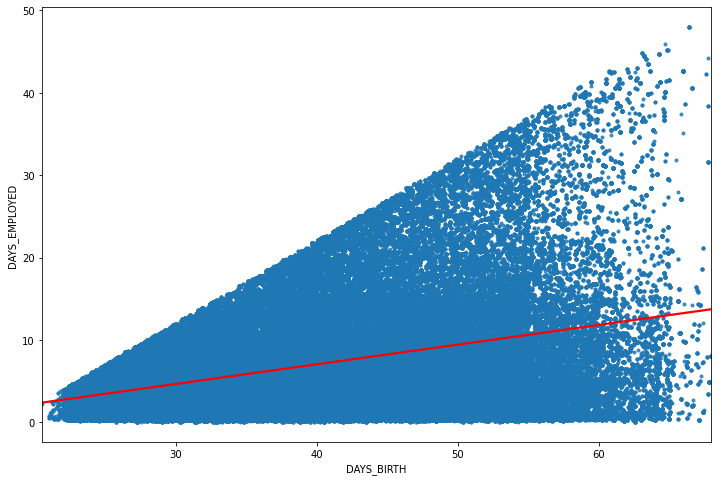

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.regplot(x='DAYS_BIRTH', y='DAYS_EMPLOYED', data=application, marker='.',line_kws={'color': 'r'} )
# use lm to predict and fill the nan value in employday

###  table 1 data preprocess

In [11]:
app = application.drop_duplicates(subset=application.columns[1:], keep='first')

In [12]:
birth_emp = app[(app.DAYS_BIRTH.notna())&(app.DAYS_EMPLOYED.notna())]

In [13]:
birth_emp.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.867899,12.435318,1,1,0,0,Unknown,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.792608,3.104723,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.320329,8.353183,1,0,1,1,Sales staff,1.0
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.193018,2.105407,1,1,1,1,Accountants,2.0
13,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,48.673511,3.268994,1,0,0,0,Laborers,2.0


In [14]:
X_fillemp= birth_emp['DAYS_BIRTH'].values.reshape(-1 ,1)
y_fillemp = birth_emp['DAYS_EMPLOYED'].values.reshape(-1)


In [15]:
lm = LinearRegression().fit(X_fillemp, y_fillemp)

In [16]:
app.DAYS_EMPLOYED.isna().sum()

15687

In [17]:
app[app['DAYS_EMPLOYED'].isna()][['DAYS_BIRTH', 'DAYS_EMPLOYED']]

,DAYS_BIRTH,DAYS_EMPLOYED
7,61.503080,NaN
76,55.266256,NaN
160,61.106092,NaN
216,51.148528,NaN
239,61.138946,NaN
...,...,...
438449,58.527036,NaN
438499,53.221081,NaN
438525,59.608487,NaN
438545,51.559206,NaN


### use linear model to fill nan value 

In [18]:
app['DAYS_EMPLOYED'] = app[['DAYS_BIRTH', 'DAYS_EMPLOYED']].apply(
    lambda x :lm.predict(np.array([x['DAYS_BIRTH']]).reshape(1,-1))[0] 
    if pd.isna(x['DAYS_EMPLOYED']) else x["DAYS_EMPLOYED"], axis=1)

In [19]:
app.DAYS_EMPLOYED.isna().sum()

0

In [20]:
app[['DAYS_BIRTH', 'DAYS_EMPLOYED']].head()

,DAYS_BIRTH,DAYS_EMPLOYED
0,32.867899,12.435318
2,58.792608,3.104723
3,52.320329,8.353183
7,61.503080,11.534787
10,46.193018,2.105407


In [21]:
app.rename(columns={
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'car',
    'FLAG_OWN_REALTY': 'realty',
    'CNT_CHILDREN': 'num_of_children',
    'AMT_INCOME_TOTAL': 'total_income',
    'NAME_INCOME_TYPE': 'income_resource',
    'NAME_EDUCATION_TYPE': 'edu_level',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'DAYS_BIRTH': 'age',
    'DAYS_EMPLOYED': 'employed_years',
    'FLAG_MOBIL': 'mobile',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE':'phone',
    'FLAG_EMAIL': 'email',
    'OCCUPATION_TYPE':'occupation',
    'CNT_FAM_MEMBERS': 'num_of_fam_member',
}, inplace=True)

In [22]:
app.drop(labels=['mobile'], axis=1, inplace=True)

In [23]:
app.isna().sum()

ID                   0
gender               0
car                  0
realty               0
num_of_children      0
total_income         0
income_resource      0
edu_level            0
family_status        0
housing_type         0
age                  0
employed_years       0
work_phone           0
phone                0
email                0
occupation           0
num_of_fam_member    0
dtype: int64

In [24]:
app.num_of_fam_member.fillna(value=app.num_of_fam_member.mean(), inplace=True)

In [25]:
app.describe().drop('ID', axis=1)

,num_of_children,total_income,age,employed_years,work_phone,phone,email,num_of_fam_member
count,90085.000000,9.008500e+04,90085.000000,90085.000000,90085.000000,90085.000000,90085.000000,90085.000000
mean,0.423811,1.787001e+05,43.536247,7.433892,0.202953,0.274496,0.100228,2.177288
std,0.726697,1.024630e+05,11.650874,6.006665,0.402200,0.446263,0.300305,0.904672
min,0.000000,2.610000e+04,20.503765,0.032854,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.125000e+05,33.782341,2.696783,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.575000e+05,42.617385,6.258727,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,53.193703,10.971744,0.000000,1.000000,0.000000,3.000000
max,19.000000,6.750000e+06,68.996578,47.997262,1.000000,1.000000,1.000000,20.000000


#### based on min and max value of describe df above , we found that some outlier are in chilren, emplyed_days and family member column

In [26]:
app.employed_years.value_counts()

0.596851     62
1.177276     61
0.632444     59
0.681725     53
0.594114     53
             ..
19.958932     1
32.501027     1
10.164361     1
10.043129     1
9.531328      1
Name: employed_years, Length: 15252, dtype: int64

In [27]:
app.num_of_children.value_counts()

0     62723
1     18026
2      8075
3      1114
4       114
5        25
7         2
6         2
19        1
14        1
12        1
9         1
Name: num_of_children, dtype: int64

In [28]:
app.num_of_fam_member.value_counts()

2.0     47397
1.0     18389
3.0     15631
4.0      7483
5.0      1047
6.0       106
7.0        24
9.0         2
8.0         2
11.0        1
15.0        1
14.0        1
20.0        1
Name: num_of_fam_member, dtype: int64

In [29]:
app_new = app[(app.employed_years<100)&(app.num_of_children<10)]

In [30]:
app_new['num_of_fam_member']=app_new.num_of_fam_member.astype('int')

In [31]:
app_new

,ID,gender,car,realty,num_of_children,total_income,income_resource,edu_level,family_status,housing_type,age,employed_years,work_phone,phone,email,occupation,num_of_fam_member
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.867899,12.435318,1,0,0,Unknown,2
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.792608,3.104723,0,0,0,Security staff,2
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.320329,8.353183,0,1,1,Sales staff,1
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.503080,11.534787,0,0,0,Unknown,1
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.193018,2.105407,1,1,1,Accountants,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438541,6837707,M,N,Y,0,202500.0,Working,Higher education,Civil marriage,House / apartment,36.988364,6.321697,1,0,0,Laborers,2
438545,6839651,F,N,Y,3,99000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,51.559206,9.265117,0,0,0,Unknown,1
438547,6839917,F,N,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,30.023272,7.403149,0,0,0,Unknown,2
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,62.195756,11.692889,0,0,0,Unknown,1


### table 2 data preprocess

In [32]:
credit.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


In [33]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


### It looks like there is no outlier value. We seperate the potential applicants of high and low risk by STATUS == 3 that the customers did not pay credit card bill after 3 months later of the due day. we can ignore the month feature and only reference the status feature

In [34]:
# credit['STATUS'] = credit.STATUS.apply(lambda x : 0 if x in ('X' 'C'))
credit.STATUS.replace('X', 0, inplace=True)
credit.STATUS.replace('C', 0, inplace=True)

credit['STATUS'] = credit.STATUS.astype('int')
credit_record = credit.groupby('ID').STATUS.max()

In [35]:
df = app_new.merge(credit_record, how='inner', on='ID')

In [36]:
df.head(20)

,ID,gender,car,realty,num_of_children,total_income,income_resource,edu_level,family_status,housing_type,age,employed_years,work_phone,phone,email,occupation,num_of_fam_member,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.867899,12.435318,1,0,0,Unknown,2,1
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.792608,3.104723,0,0,0,Security staff,2,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.320329,8.353183,0,1,1,Sales staff,1,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.503080,11.534787,0,0,0,Unknown,1,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.193018,2.105407,1,1,1,Accountants,2,0
5,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,48.673511,3.268994,0,0,0,Laborers,2,0
6,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,29.210130,3.019849,0,0,0,Accountants,2,1
7,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,27.463381,4.021903,0,1,0,Laborers,2,1
8,5008834,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,30.028747,4.435318,0,0,0,Unknown,2,0
9,5008836,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,34.740589,3.184120,0,0,0,Laborers,5,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9707 entries, 0 to 9706
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 9707 non-null   int64  
 1   gender             9707 non-null   object 
 2   car                9707 non-null   object 
 3   realty             9707 non-null   object 
 4   num_of_children    9707 non-null   int64  
 5   total_income       9707 non-null   float64
 6   income_resource    9707 non-null   object 
 7   edu_level          9707 non-null   object 
 8   family_status      9707 non-null   object 
 9   housing_type       9707 non-null   object 
 10  age                9707 non-null   float64
 11  employed_years     9707 non-null   float64
 12  work_phone         9707 non-null   int64  
 13  phone              9707 non-null   int64  
 14  email              9707 non-null   int64  
 15  occupation         9707 non-null   object 
 16  num_of_fam_member  9707 

In [38]:
df.describe()

,ID,num_of_children,total_income,age,employed_years,work_phone,phone,email,num_of_fam_member,STATUS
count,9.707000e+03,9707.000000,9.707000e+03,9707.000000,9707.000000,9707.000000,9707.000000,9707.000000,9707.000000,9707.000000
mean,5.076103e+06,0.419491,1.812308e+05,43.784089,7.595731,0.217369,0.287627,0.087566,2.179458,0.181003
std,4.080556e+04,0.730670,9.928409e+04,11.625815,6.020474,0.412477,0.452680,0.282677,0.906020,0.590028
min,5.008804e+06,0.000000,2.700000e+04,20.503765,0.046543,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.036954e+06,0.000000,1.125000e+05,34.060233,2.844627,0.000000,0.000000,0.000000,2.000000,0.000000
50%,5.069449e+06,0.000000,1.575000e+05,42.740589,6.499658,0.000000,0.000000,0.000000,2.000000,0.000000
75%,5.112986e+06,1.000000,2.250000e+05,53.567420,11.058080,0.000000,1.000000,0.000000,3.000000,0.000000
max,5.150479e+06,7.000000,1.575000e+06,68.862423,43.019849,1.000000,1.000000,1.000000,9.000000,5.000000


In [39]:
df['decline'] = df.STATUS.apply(lambda x : 1 if x in (3, 4, 5) else 0)

In [40]:
df.decline.value_counts()

0    9597
1     110
Name: decline, dtype: int64

## 2. EDA and Data visualization

### Binary features
There are 6 binary features in the dataset gender, car, realty, work_phone, phone and Email.

In [41]:
binary_features = ['gender', 'car', 'realty', 'work_phone', 'phone', 'email']

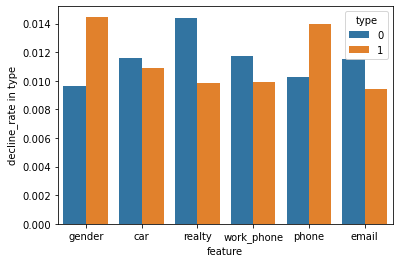

,feature,type,decline_rate in type,count,decline_count
0,gender,0,0.009649,6322,61
1,gender,1,0.014476,3385,49
2,car,0,0.011567,6138,71
3,car,1,0.010927,3569,39
4,realty,0,0.014425,3189,46
5,realty,1,0.009819,6518,64
6,work_phone,0,0.011715,7597,89
7,work_phone,1,0.009953,2110,21
8,phone,0,0.010268,6915,71
9,phone,1,0.013968,2792,39


In [42]:
binary_df = df[binary_features+['decline']].replace('M', 1).replace('F', 0).replace('Y', 1).replace('N', 0)
dict_list = []
for feature in binary_features:
    for one_type in [0, 1]:
        dict_list.append({'feature': feature,
                          'type': one_type,
                          'decline_rate in type': len(binary_df[binary_df[feature]==one_type][binary_df.decline==1])/len(binary_df[binary_df[feature]==one_type]),
                          'count': len(binary_df[binary_df[feature]==one_type]),
                          'decline_count': len(binary_df[binary_df[feature]==one_type][binary_df.decline==1])
                         })

group_binary = pd.DataFrame.from_dict(dict_list)
sns.barplot(x="feature", y="decline_rate in type", hue="type", data=group_binary)
plt.show()
group_binary

#### In the figure above, we can notice that gender/realty/phone are high value columns for credit approval, but car/work_phone/email are not.

###  Digital features
There are 5 digital features in the dataset num_of_children, total_income, birthday, employed_days and num_of_fam_member. num_of_children and num_of_fam_member are features with a small scale.

####  number of children

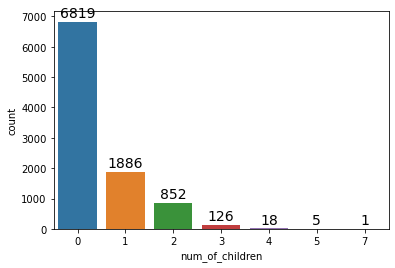

In [43]:
sns.countplot(x="num_of_children", data=df)
num_of_children = df.num_of_children.value_counts()
for a,b in zip(range(len(num_of_children)), num_of_children):
    plt.text(a, b+50, '%.0f' % b, ha='center', va= 'bottom',fontsize=14)
plt.show()

#### From the figure above, we can find that few of applicants have more than 2 child, so we seperate the applicants into four parts.

In [44]:
num_of_children_4 = [num_of_children[0], num_of_children[1], num_of_children[2], num_of_children[3:].sum()]
num_of_children_4_decline = [len(df[df.num_of_children==0][df.decline==1]),
                           len(df[df.num_of_children==1][df.decline==1]),
                           len(df[df.num_of_children==2][df.decline==1]),
                           len(df[df.num_of_children>=3][df.decline==1])]

num_of_children_df = pd.DataFrame.from_dict({'num_of_children':num_of_children_4, 'decline_count':num_of_children_4_decline})
num_of_children_df['approved_count'] = num_of_children_df.num_of_children - num_of_children_df.decline_count
num_of_children_df['decline_rate'] = num_of_children_df.decline_count/num_of_children_df.num_of_children
num_of_children_df

,num_of_children,decline_count,approved_count,decline_rate
0,6819,75,6744,0.010999
1,1886,25,1861,0.013256
2,852,9,843,0.010563
3,150,1,149,0.006667


#### The decline rate of applicants with 0, 1 or 2 children are not quite different.

####  Number_of_family_members

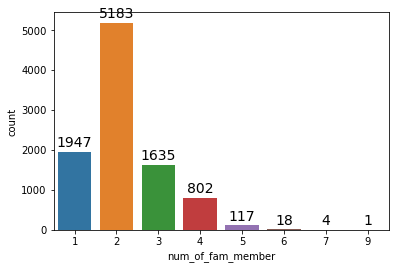

In [45]:
sns.countplot(x="num_of_fam_member", data=df)
num_of_fam_member = df.num_of_fam_member.apply(int).value_counts().sort_index()
for a,b in zip(range(len(num_of_fam_member)), num_of_fam_member):
    plt.text(a, b+50, '%.0f' % b, ha='center', va= 'bottom',fontsize=14)
plt.show()

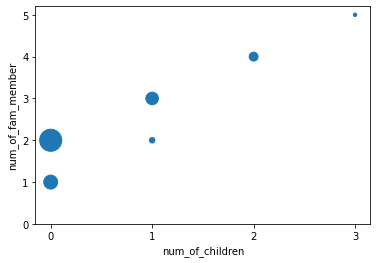

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
gp=df.groupby(by=['num_of_children','num_of_fam_member'])
gp_df = gp.size().reset_index(name='times').sort_values('times', ascending=False)[:6]
gp_df['times_10'] = gp_df['times'].apply(lambda x: x/10)
ax.scatter(gp_df['num_of_children'], gp_df['num_of_fam_member'], s=gp_df['times_10'])
plt.xticks(range(4))
plt.yticks(range(6))
plt.xlabel('num_of_children')
plt.ylabel('num_of_fam_member')
plt.show()

#### Most families are on the left side of the distribution

#### 2.2.3 total_income

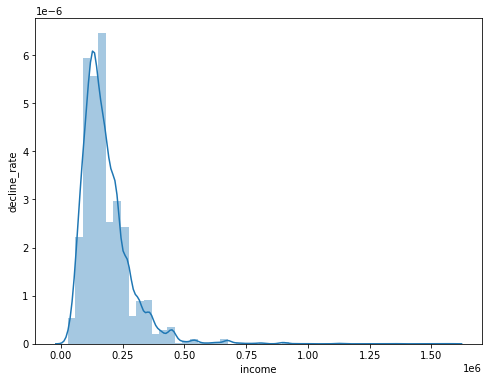

In [47]:
income_plot = pd.Series(df.total_income, name="income")
plt.figure(figsize=(8,6))
plt.ylabel('decline_rate')
sns.distplot(income_plot)  
plt.show()

#### The total income with decline rate is in left skewed distribution，and most applicants' income is lower than 40000

### Age

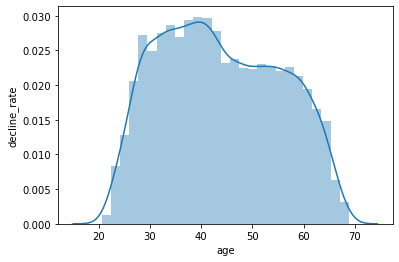

In [48]:
age_series = df.age
plt.ylabel('decline_rate')
age_plot = pd.Series(age_series, name="age")
sns.distplot(age_plot)
plt.show()

####  The age with decline rate is almost  in normal distribution 

####  employed_years

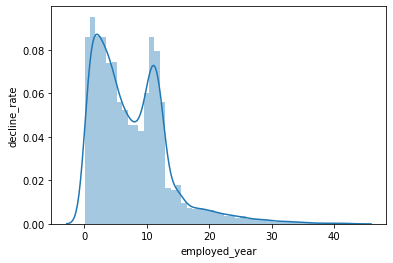

In [49]:
employed_year_series = df.employed_years
plt.ylabel('decline_rate')
employed_year_plot = pd.Series(employed_year_series, name="employed_year")
sns.distplot(employed_year_plot)
plt.show()

#### The employed_year with decline rate is almost in normal distribution

### Class features

#### income_resource

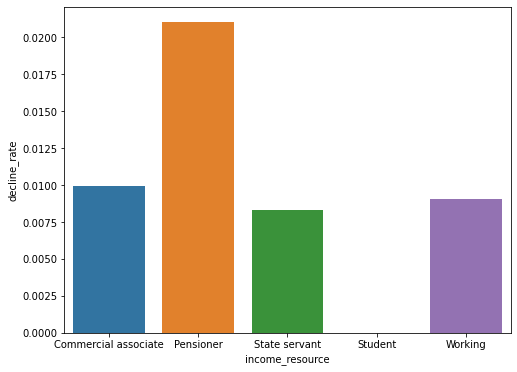

,income_resource,times,decline_times,decline_rate
0,Commercial associate,2312,23.0,0.009948
1,Pensioner,1712,36.0,0.021028
2,State servant,722,6.0,0.008310
3,Student,3,0.0,0.000000
4,Working,4958,45.0,0.009076


In [50]:
gp_total=df.groupby(by=['income_resource']).size().reset_index(name='times')
gp_decline = df[df.decline==1].groupby(by=['income_resource']).size().reset_index(name='decline_times')
gp_decline_rate = pd.merge(gp_total, gp_decline, how='outer', on=['income_resource']).fillna(0)
gp_decline_rate['decline_rate'] = gp_decline_rate.decline_times / gp_decline_rate.times
plt.figure(figsize=(8,6))
sns.barplot(x="income_resource", y="decline_rate", data=gp_decline_rate)
plt.show()
gp_decline_rate

#### Pensioner had the highest decline rate, which may be due to its high risk tolerance

#### education_level

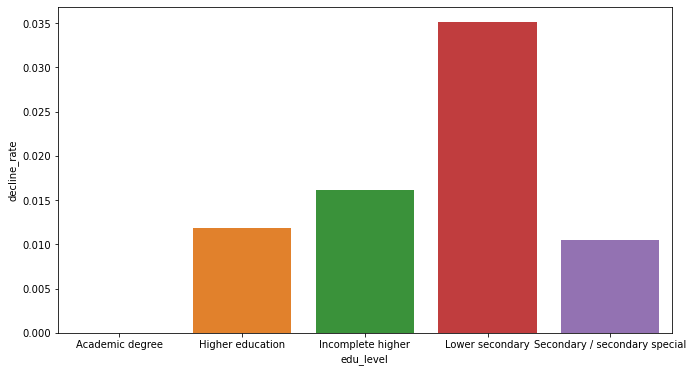

,edu_level,times,decline_times,decline_rate
0,Academic degree,6,0.0,0.000000
1,Higher education,2457,29.0,0.011803
2,Incomplete higher,371,6.0,0.016173
3,Lower secondary,114,4.0,0.035088
4,Secondary / secondary special,6759,71.0,0.010505


In [51]:
gp_total=df.groupby(by=['edu_level']).size().reset_index(name='times')
gp_decline = df[df.decline==1].groupby(by=['edu_level']).size().reset_index(name='decline_times')
gp_decline_rate = pd.merge(gp_total, gp_decline, how='outer', on=['edu_level']).fillna(0)
gp_decline_rate['decline_rate'] = gp_decline_rate.decline_times / gp_decline_rate.times
plt.figure(figsize=(11,6))
sns.barplot(x="edu_level", y="decline_rate", data=gp_decline_rate)
plt.show()
gp_decline_rate

#### The higher the education, the lower the decline rate

#### family_status

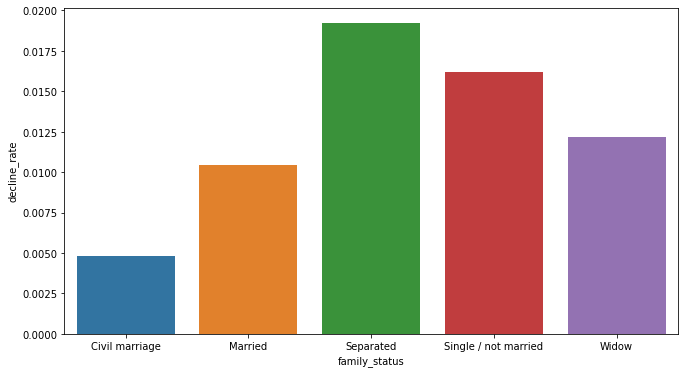

,family_status,times,decline_times,decline_rate
0,Civil marriage,836,4,0.004785
1,Married,6530,68,0.010413
2,Separated,573,11,0.019197
3,Single / not married,1358,22,0.016200
4,Widow,410,5,0.012195


In [52]:
gp_total=df.groupby(by=['family_status']).size().reset_index(name='times')
gp_decline = df[df.decline==1].groupby(by=['family_status']).size().reset_index(name='decline_times')
gp_decline_rate = pd.merge(gp_total, gp_decline, how='outer', on=['family_status']).fillna(0)
gp_decline_rate['decline_rate'] = gp_decline_rate.decline_times / gp_decline_rate.times
plt.figure(figsize=(11,6))
sns.barplot(x="family_status", y="decline_rate", data=gp_decline_rate)
plt.show()
gp_decline_rate

#### A client with a stable marriage has a lower decline rate

#### housing type

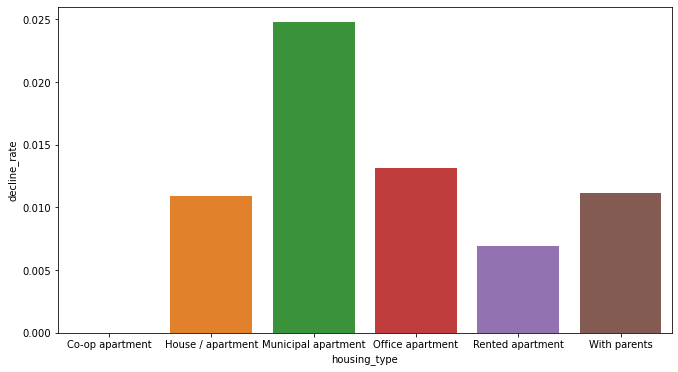

,housing_type,times,decline_times,decline_rate
0,Co-op apartment,34,0.0,0.000000
1,House / apartment,8682,95.0,0.010942
2,Municipal apartment,323,8.0,0.024768
3,Office apartment,76,1.0,0.013158
4,Rented apartment,144,1.0,0.006944
5,With parents,448,5.0,0.011161


In [53]:
gp_total=df.groupby(by=['housing_type']).size().reset_index(name='times')
gp_decline = df[df.decline==1].groupby(by=['housing_type']).size().reset_index(name='decline_times')
gp_decline_rate = pd.merge(gp_total, gp_decline, how='outer', on=['housing_type']).fillna(0)
gp_decline_rate['decline_rate'] = gp_decline_rate.decline_times / gp_decline_rate.times
plt.figure(figsize=(11,6))
sns.barplot(x="housing_type", y="decline_rate", data=gp_decline_rate)
plt.show()
gp_decline_rate

#### A client living in a Municipal Apartment has the highest decline rate

####  occupation type

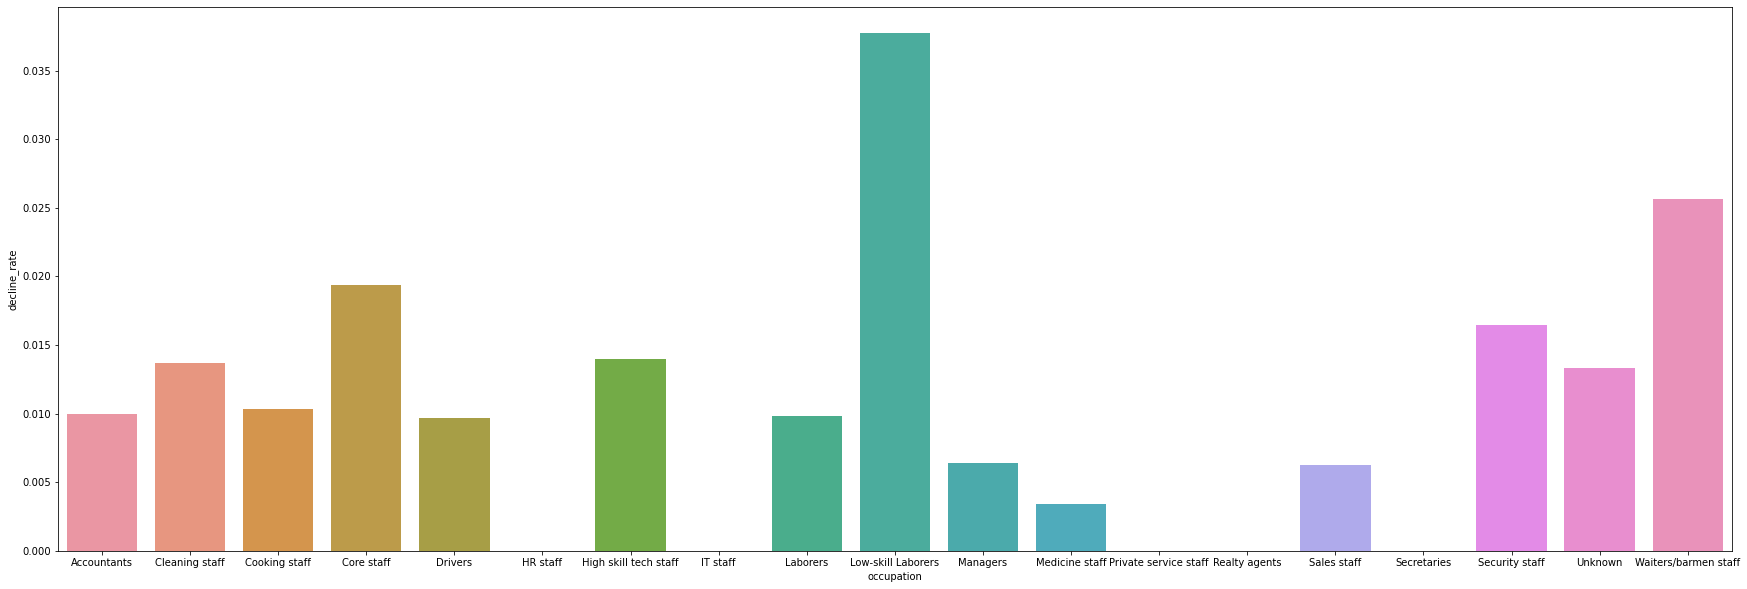

,occupation,times,decline_times,decline_rate
0,Accountants,300,3.0,0.010000
1,Cleaning staff,146,2.0,0.013699
2,Cooking staff,193,2.0,0.010363
3,Core staff,877,17.0,0.019384
4,Drivers,622,6.0,0.009646
5,HR staff,22,0.0,0.000000
6,High skill tech staff,357,5.0,0.014006
7,IT staff,18,0.0,0.000000
8,Laborers,1724,17.0,0.009861
9,Low-skill Laborers,53,2.0,0.037736


In [54]:
gp_total=df.groupby(by=['occupation']).size().reset_index(name='times')
gp_decline = df[df.decline==1].groupby(by=['occupation']).size().reset_index(name='decline_times')
gp_decline_rate = pd.merge(gp_total, gp_decline, how='outer', on=['occupation']).fillna(0)
gp_decline_rate['decline_rate'] = gp_decline_rate.decline_times / gp_decline_rate.times
plt.figure(figsize=(30,10))  
sns.barplot(x="occupation", y="decline_rate", data=gp_decline_rate)
plt.show()     
gp_decline_rate

#### Customers with low job skills have highest risk of decline rate

## 3. Build models

### Information Value

In [55]:
def calc_iv(df, target, feature):
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        total = df[df[feature] == val].count()[feature]
        GoodPre = df[(df[feature] == val) & (df[target] == 0)].count()[target]
        BadPre = df[(df[feature] == val) & (df[target] == 1)].count()[target]
        lst.append([feature, val, total, GoodPre, BadPre])
    
    temp = pd.DataFrame(lst, columns=['Var', 'Value', 'Total', 'Good', 'Bad'])
    temp['Share'] = temp['Total'] / temp['Total'].sum()
    temp['Bad Rate'] = temp['Bad'] / temp['Total']
    temp['Good_distri'] = temp['Good'] / temp['Good'].sum()
    temp['Bad_distri'] = temp['Bad'] / temp['Bad'].sum()
    temp['WoE'] = np.log(temp['Good_distri'] / temp['Bad_distri'])
    temp['IV'] = temp['WoE'] * (temp['Good_distri'] - temp['Bad_distri'])

    temp = temp.sort_values(by=['Var', 'Value'], ascending=[True, True])
    temp.index = range(len(temp.index))
    
    iv = round(temp['IV'].sum(),5)
    if ((iv == np.inf) | (iv == -np.inf)):
        iv = 0
    return iv

In [56]:
df_copy = df.copy()

In [57]:
col_name = df_copy.columns[(df_copy.columns != 'decline') & (df_copy.columns != 'ID')]

In [58]:
lst1 = []
for i in col_name:
     lst1.append(calc_iv(df_copy, 'decline', i))

In [59]:
ivdf = pd.DataFrame({
    'Var': col_name,
    'IV_Value': lst1})
ivdf

,Var,IV_Value
0,gender,0.04017
1,car,0.00076
2,realty,0.03530
3,num_of_children,0.00000
4,total_income,0.00000
5,income_resource,0.00000
6,edu_level,0.00000
7,family_status,0.09288
8,housing_type,0.00000
9,age,0.00000


### so we can see this is inbalance datasets, which may cause some bias when the data implemented in ML training; hence we can use SMOTE NC algorithm to "create" some data to make sure that we can even labels

In [60]:
df_new = pd.get_dummies(data=df, columns=['gender', 'car', 'realty', 'income_resource', 'edu_level', 'family_status','housing_type','occupation'])

In [61]:
df_new.head()

,ID,num_of_children,total_income,age,employed_years,work_phone,phone,email,num_of_fam_member,STATUS,...,occupation_Low-skill Laborers,occupation_Managers,occupation_Medicine staff,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Unknown,occupation_Waiters/barmen staff
0,5008804,0,427500.0,32.867899,12.435318,1,0,0,2,1,...,0,0,0,0,0,0,0,0,1,0
1,5008806,0,112500.0,58.792608,3.104723,0,0,0,2,0,...,0,0,0,0,0,0,0,1,0,0
2,5008808,0,270000.0,52.320329,8.353183,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,5008812,0,283500.0,61.503080,11.534787,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,5008815,0,270000.0,46.193018,2.105407,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
X = df_new.drop(columns=['ID','STATUS','decline'])
y = df_new.decline

#### split the data and make sure that the data stratified by label

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

#### train oversample transfer

In [64]:
smotenc = SMOTENC([4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53],random_state = 42) 

In [65]:
X_over, y_over = smotenc.fit_resample(X_train, y_train)

In [66]:
def show_info(grid, X_test, y_test):
    print("Best params:\n{}\n".format(grid.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

#### use GridSearch to find best parameters for the models

In [67]:
param_grid = [
    {'preprocessing':[StandardScaler()],
    'classifier':[RidgeClassifier()],
    'classifier__alpha':[x for x in range(1, 100, 10)],
    'classifier__max_iter': [3000,]
    },
    
    {'preprocessing':[StandardScaler()],
    'classifier':[LogisticRegression()],
    'classifier__C':[x for x in range(100, 50, -10)],
    'classifier__max_iter': [1000],
    },
 
    {'preprocessing': [None],
    'classifier': [DecisionTreeClassifier()],
    'classifier__max_depth':[x for x in range(2,15,1)],
    'classifier__criterion': ['gini', 'entropy']
     }
]

#### create a pipeline to process 

In [68]:
pipe = Pipeline([('preprocessing', StandardScaler()),('classifier', RidgeClassifier())])

### Try different scoring for the models

#### First let's try traditional accuracy score; every model performance very weill as expected.

In [69]:
print('-' * 100)
for param in param_grid:
    grid_acc = GridSearchCV(pipe, param ,scoring='accuracy', cv=10)
    grid_acc.fit(X_over, y_over)
    print('accuracy: ')
    show_info(grid_acc, X_test, y_test)
    print('='*50)

print('-' * 100)


----------------------------------------------------------------------------------------------------
accuracy: 
Best params:
{'classifier': RidgeClassifier(alpha=11, max_iter=3000), 'classifier__alpha': 11, 'classifier__max_iter': 3000, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.95
Test-set score: 0.94
accuracy: 
Best params:
{'classifier': LogisticRegression(C=100, max_iter=1000), 'classifier__C': 100, 'classifier__max_iter': 1000, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.97
Test-set score: 0.96
accuracy: 
Best params:
{'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=14), 'classifier__criterion': 'entropy', 'classifier__max_depth': 14, 'preprocessing': None}

Best cross-validation score: 0.98
Test-set score: 0.96
----------------------------------------------------------------------------------------------------


#### However, the credit card company use implement rigirous standards to qualify a potential customer, so here we use recall and roc score to make models more persuasive, however, the models' score of recall and roc are not as good as those of accuracy even with the regularization

In [70]:
print('-' * 100)
for param in param_grid:
    grid_recall = GridSearchCV(pipe, param ,scoring='recall', cv=10)
    grid_recall.fit(X_over, y_over)
    print('recall: ')
    show_info(grid_recall, X_test, y_test)
    print('='*50)

print('-' * 100)


----------------------------------------------------------------------------------------------------
recall: 
Best params:
{'classifier': RidgeClassifier(alpha=91, max_iter=3000), 'classifier__alpha': 91, 'classifier__max_iter': 3000, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.94
Test-set score: 0.03
recall: 
Best params:
{'classifier': LogisticRegression(C=100, max_iter=1000), 'classifier__C': 100, 'classifier__max_iter': 1000, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.96
Test-set score: 0.00
recall: 
Best params:
{'classifier': DecisionTreeClassifier(max_depth=14), 'classifier__criterion': 'gini', 'classifier__max_depth': 14, 'preprocessing': None}

Best cross-validation score: 0.99
Test-set score: 0.18
----------------------------------------------------------------------------------------------------


In [71]:
print('-' * 100)
for param in param_grid:
    grid_roc = GridSearchCV(pipe, param, scoring='roc_auc', cv=10)
    grid_roc.fit(X_over, y_over)
    print('roc_auc:')
    show_info(grid_roc, X_test, y_test)
    print('='*50)

print('-' * 100)


----------------------------------------------------------------------------------------------------
roc_auc:
Best params:
{'classifier': RidgeClassifier(alpha=71, max_iter=3000), 'classifier__alpha': 71, 'classifier__max_iter': 3000, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.50
roc_auc:
Best params:
{'classifier': LogisticRegression(C=60, max_iter=1000), 'classifier__C': 60, 'classifier__max_iter': 1000, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.51
roc_auc:
Best params:
{'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=12), 'classifier__criterion': 'entropy', 'classifier__max_depth': 12, 'preprocessing': None}

Best cross-validation score: 0.98
Test-set score: 0.57
----------------------------------------------------------------------------------------------------


### Conclusion；
Based on accuracy score, almost every model get very high score for this data set.
However, because we have tried models that we used in accuracy but they does not work very well; in our opinion, the classifiers are underfitting; therefore, training classifiers on largers data set may solve this problem

In [72]:
"""param_grid = [
    {'preprocessing':[StandardScaler()],
    'classifier':[RidgeClassifier()],
    'classifier__alpha':[x for x in range(1, 100, 10)],
    'classifier__max_iter': [3000,]
    },
    
    {'preprocessing':[StandardScaler()],
    'classifier':[LogisticRegression()],
    'classifier__C':[x for x in range(100, 50, -10)],
    'classifier__max_iter': [1000],
    },
    
 {'preprocessing':[StandardScaler()],
    'classifier':[LogisticRegression()],
    'classifier__C':[x for x in range(100, 50, -10)],
    'classifier__max_iter': [3000],
    'classifier__penalty':['l1'],
    'classifier__solver':['liblinear' ,'saga' ]
    },
    
    {'preprocessing':[StandardScaler()],
    'classifier':[LogisticRegression()],
    'classifier__C':[x for x in range(100, 1, -10)],
    'classifier__max_iter': [3000],
    'classifier__penalty':['l2'],
    'classifier__solver':['saga' ]
    'classifier__solver':['newton-cg', 'lbfgs', 'sag' , 'saga' ]
    },
    
    
    {'preprocessing':[StandardScaler()],
    'classifier':[LogisticRegression()],
    'classifier__C':[x for x in range(100, 1, -10)],
    'classifier__max_iter': [3000],
    'classifier__penalty':['elasticnet'],
    'classifier__solver':['saga' ]
    },
    
    
    {'preprocessing': [None],
    'classifier': [DecisionTreeClassifier()],
    'classifier__max_depth':[x for x in range(2,15,1)],
    'classifier__criterion': ['gini', 'entropy']
     }
]"""

"param_grid = [\n    {'preprocessing':[StandardScaler()],\n    'classifier':[RidgeClassifier()],\n    'classifier__alpha':[x for x in range(1, 100, 10)],\n    'classifier__max_iter': [3000,]\n    },\n    \n    {'preprocessing':[StandardScaler()],\n    'classifier':[LogisticRegression()],\n    'classifier__C':[x for x in range(100, 50, -10)],\n    'classifier__max_iter': [1000],\n    },\n    \n {'preprocessing':[StandardScaler()],\n    'classifier':[LogisticRegression()],\n    'classifier__C':[x for x in range(100, 50, -10)],\n    'classifier__max_iter': [3000],\n    'classifier__penalty':['l1'],\n    'classifier__solver':['liblinear' ,'saga' ]\n    },\n    \n    {'preprocessing':[StandardScaler()],\n    'classifier':[LogisticRegression()],\n    'classifier__C':[x for x in range(100, 1, -10)],\n    'classifier__max_iter': [3000],\n    'classifier__penalty':['l2'],\n    'classifier__solver':['saga' ]\n    'classifier__solver':['newton-cg', 'lbfgs', 'sag' , 'saga' ]\n    },\n    \n    \n 